In [1]:
from qiskit import qpy
from qiskit.circuit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt
from QuditsOnQubits import create_ame43, create_graph_ghz, create_ghz
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_transpiler import generate_ai_pass_manager

In [2]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [3]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

In [5]:
backend = QiskitRuntimeService().backend("ibm_aachen")

In [28]:
target = backend.target

In [6]:
estimator = Estimator(mode=backend)

In [7]:
with open('Zgate.qpy', 'rb') as fd:
    Zgate = qpy.load(fd)[0]

with open('Xgate.qpy', 'rb') as fd:
    Xgate = qpy.load(fd)[0]

with open('Fgate.qpy', 'rb') as fd:
    Fgate = qpy.load(fd)[0]

with open('CZ.qpy', 'rb') as fd:
    CZgate = qpy.load(fd)[0]

with open('FDAGgate.qpy', 'rb') as fd:
    FDAGgate = qpy.load(fd)[0]

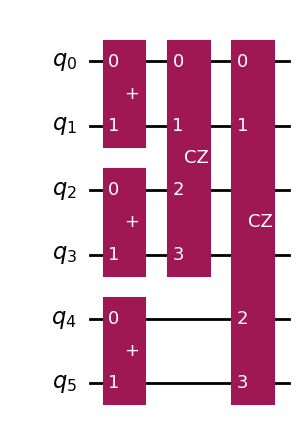

In [8]:
ghz_qc = create_ghz()
ghz_qc = ghz_qc[0]
ghz_qc.draw('mpl')

In [109]:
'''
Stabilizator XZZ
'''

stab_ghz1 = QuantumCircuit(6)
stab_ghz1.append(Xgate, [0, 1])
stab_ghz1.append(Zgate, [2, 3])
stab_ghz1.append(Zgate, [4, 5])

#op_stabghz1 = SparsePauliOp.from_operator(Operator(stab_ghz1))

'''
Stabilizator ZXI
'''

stab_ghz2 = QuantumCircuit(6)
stab_ghz2.append(Zgate, [0, 1])
stab_ghz2.append(Xgate, [2, 3])

#op_stabghz2 = SparsePauliOp.from_operator(Operator(stab_ghz2))

'''
Stabilizator ZIX
'''

stab_ghz3 = QuantumCircuit(6)
stab_ghz3.append(Zgate, [0, 1])
stab_ghz3.append(Xgate, [4, 5])

#op_stabghz3 = SparsePauliOp.from_operator(Operator(stab_ghz3))

In [33]:
ai_transpiler_pass_manager = generate_ai_pass_manager(
    ai_optimization_level=3,
    optimization_level=3,
    ai_layout_mode="optimize",
    backend=backend,
)

In [11]:
best_isa_qc = ai_transpiler_pass_manager.run(ghz_qc)

for i in range(100):
    isa_ame43_qc_ai2 = ai_transpiler_pass_manager.run(ghz_qc)
    if isa_ame43_qc_ai2.depth() <= best_isa_qc.depth():
        best_isa_qc = isa_ame43_qc_ai2.copy()
        print(isa_ame43_qc_ai2.depth())

INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


73
71


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.a

In [12]:
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins

In [13]:
list_plugins = list_stage_plugins("translation")

In [29]:
pm = generate_preset_pass_manager(target=target, optimization_level=3)

In [126]:
from qiskit.transpiler import TranspilerError

def translation_opti(qc):
    list_plugins = list_stage_plugins("translation")

    list_of_best = np.zeros(len(list_plugins))
    k = 0
    pm_trans = generate_preset_pass_manager(target=target, optimization_level=3, translation_method=list_plugins[0])
    best_qc = pm_trans.run(qc)
    for name_plugin in list_plugins:
        try:
            print(f'-------- {name_plugin} --------')
            for i in range(100):
                temp_qc = pm_trans.run(qc)
                if temp_qc.depth() < best_qc.depth():
                    best_qc = temp_qc.copy()
                    list_of_best[k] = best_qc.depth()
                    print(best_qc.depth())
        except TranspilerError:
            print(f'TranspilerError {name_plugin}')
            continue
    return best_qc


In [127]:
best_standard_qc = translation_opti(ghz_qc)

-------- default --------
81
-------- synthesis --------
-------- translator --------
-------- ibm_backend --------
-------- ibm_dynamic_circuits --------
-------- ibm_fractional --------


In [128]:
best_standard_qc.depth()

81

In [45]:
translation_opti(best_isa_qc).depth()

-------- default --------
-------- synthesis --------
-------- translator --------
-------- ibm_backend --------
-------- ibm_dynamic_circuits --------
-------- ibm_fractional --------


71

In [ ]:
translation_opti(ghz_qc)

In [20]:
best_isa_qc.depth()

71

In [158]:
ops_list = [Operator(stab_ghz1), Operator(stab_ghz2), Operator(stab_ghz3)]
op_A_ai = []
op_B_ai = []
op_A_stand = []
op_B_stand = []


for op in ops_list:
    A_op = (0.5 * (op + op.adjoint()))
    B_op = (-0.5j * (op - op.adjoint()))

    A = SparsePauliOp.from_operator(A_op)
    B = SparsePauliOp.from_operator(B_op)

    isa_ghz_observable_A = A.apply_layout(layout=best_isa_qc.layout)
    isa_ghz_observable_B = B.apply_layout(layout=best_isa_qc.layout)

    op_A_ai.append([isa_ghz_observable_A])
    op_B_ai.append([isa_ghz_observable_B])

    isa_ghz_observable_A_stand = A.apply_layout(layout=best_standard_qc.layout)
    isa_ghz_observable_B_stand = B.apply_layout(layout=best_standard_qc.layout)

    op_A_stand.append([isa_ghz_observable_A_stand])
    op_B_stand.append([isa_ghz_observable_B_stand])

In [130]:
np.iscomplexobj(np.real_if_close(op_A_stand[2][0].coeffs))

False

In [131]:
aer = AerEstimator()
aer.options.default_shots = 10_000

In [132]:
exp_ai = []
exp_stand = []

for op in op_A_ai:
    job = aer.run(best_isa_qc, op)
    exp_val = job.result().values[0]
    exp_ai.append(exp_val.round(3))

for op in op_A_stand:
    job = aer.run(best_standard_qc, op)
    exp_val = job.result().values[0]
    exp_stand.append(exp_val.round(3))

print("AI qc expectation values:")
print(exp_ai)
print("Standard qc expectation values:")
print(exp_stand)

AI qc expectation values:
[np.float64(1.023), np.float64(0.991), np.float64(1.048)]
Standard qc expectation values:
[np.float64(0.975), np.float64(0.986), np.float64(0.978)]


In [121]:
pub_ai = (best_isa_qc, op_A_ai)
pub_stand = (best_standard_qc, op_A_stand)

In [122]:
job_result_AI_qc = estimator.run(pubs=[pub_ai]).result()
job_result_AI_qc[0].data.evs

array([[0.81991183],
       [0.86449601],
       [0.91445524]])

In [133]:
job_result_AI_qc[0].data.stds

array([[0.01118587],
       [0.01132577],
       [0.01088561]])

In [123]:
job_result_stand_qc = estimator.run(pubs=[pub_stand]).result()
job_result_stand_qc[0].data.evs

array([[0.88465267],
       [0.88165582],
       [0.94845917]])

In [134]:
job_result_stand_qc[0].data.stds

array([[0.01141829],
       [0.01064789],
       [0.01114762]])

In [135]:
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.transpiler import PassManager
from qiskit.visualization import timeline_drawer
from qiskit.circuit.library import XGate, YGate

In [136]:
X = XGate()
Y = YGate()

dd_sequence = [X, Y, X, Y]

In [137]:
target = backend.target

basis_gates = list(target.operation_names)
basis_gates

['x', 'reset', 'measure', 'cz', 'delay', 'rz', 'sx', 'id']

In [138]:
from qiskit.transpiler import InstructionProperties

y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )

target.add_instruction(YGate(), y_gate_properties)

In [139]:
dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
)

In [140]:
qc_ai_dd = dd_pm.run(best_isa_qc)
qc_stand_dd = dd_pm.run(best_standard_qc)

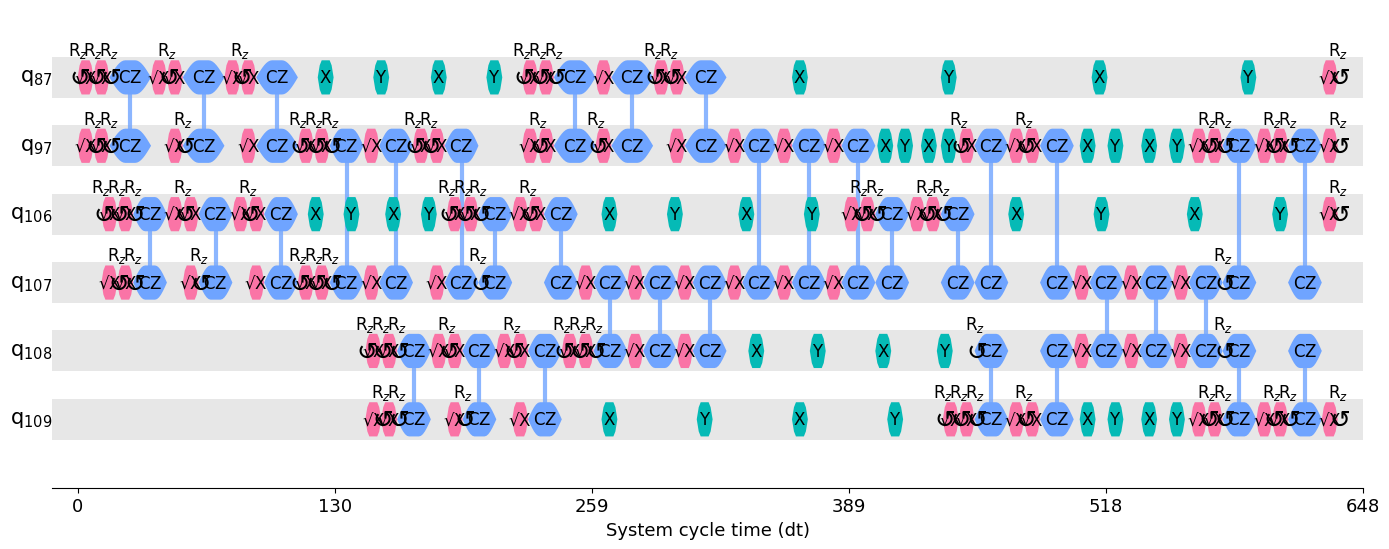

In [141]:
timeline_drawer(qc_ai_dd, idle_wires=False, target=target)

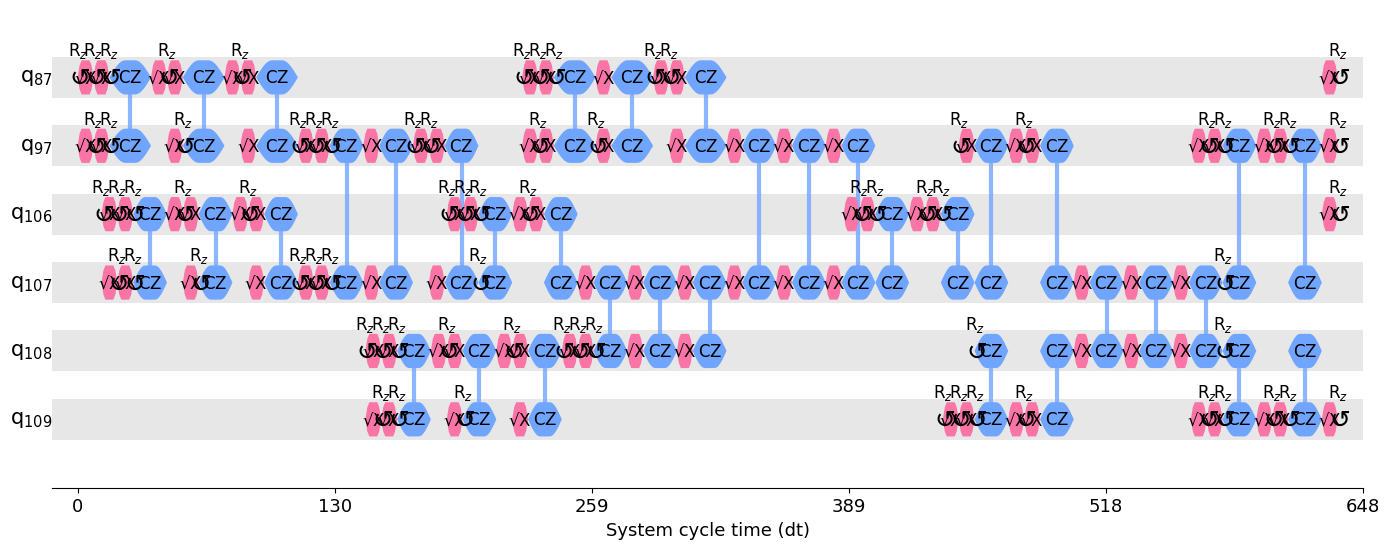

In [142]:
timeline_drawer(best_isa_qc, idle_wires=False, target=target)


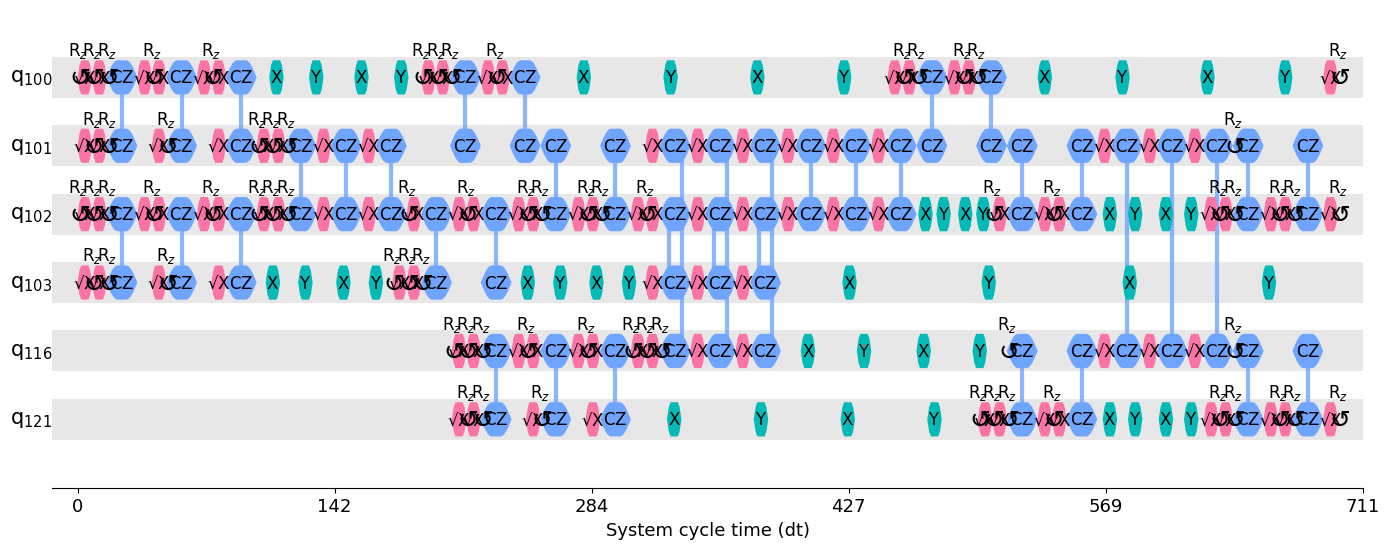

In [143]:
timeline_drawer(qc_stand_dd, idle_wires=False, target=target)

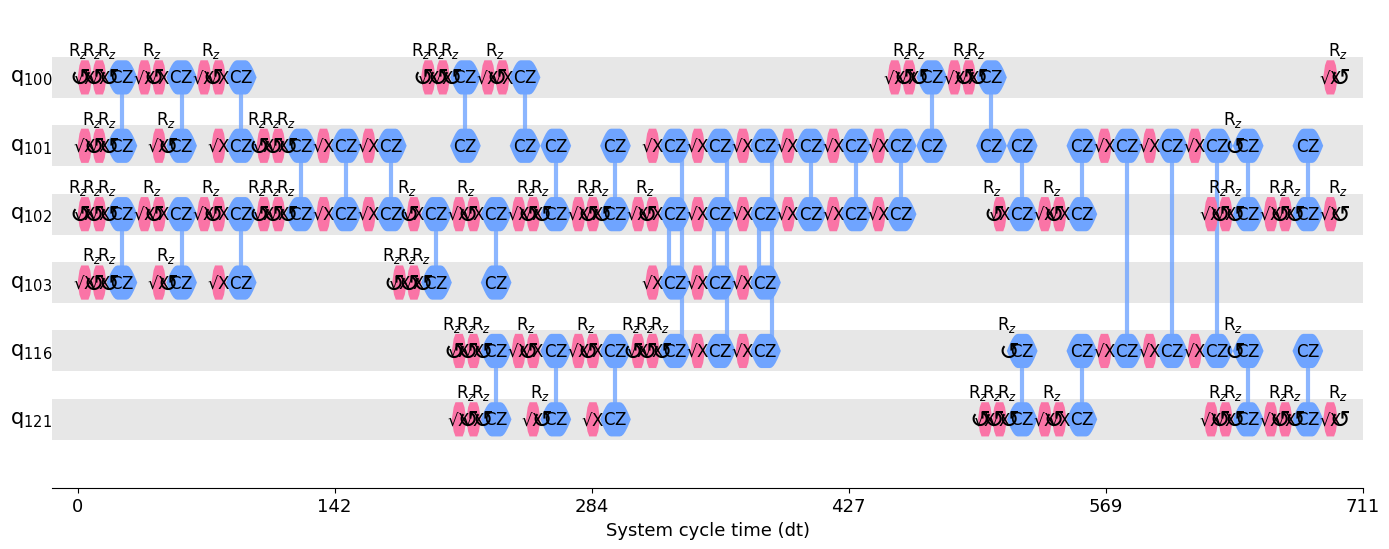

In [144]:
timeline_drawer(best_standard_qc, idle_wires=False, target=target)

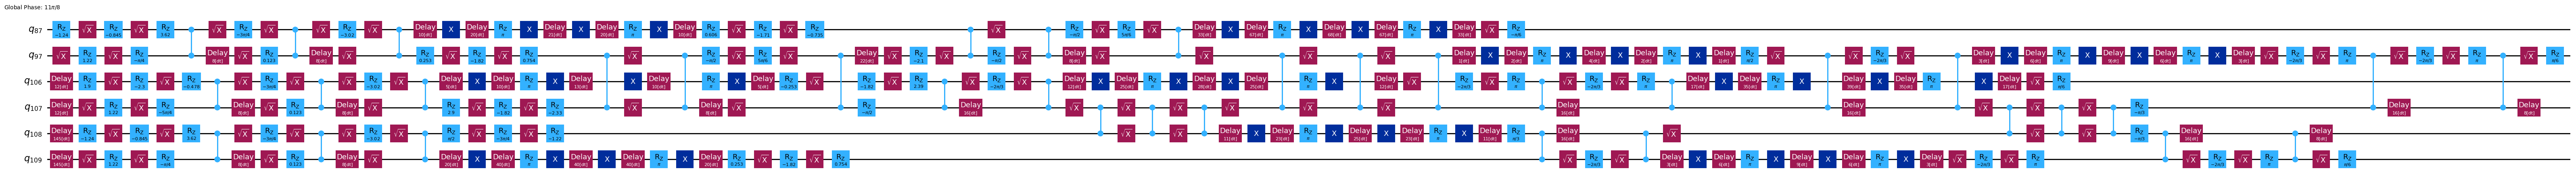

In [145]:
from qiskit.circuit.equivalence_library import (
    SessionEquivalenceLibrary as sel,
)
from qiskit.transpiler.passes import BasisTranslator

qc_ai_dd = BasisTranslator(sel, basis_gates)(qc_ai_dd)
qc_ai_dd.draw("mpl", fold=-1, idle_wires=False)

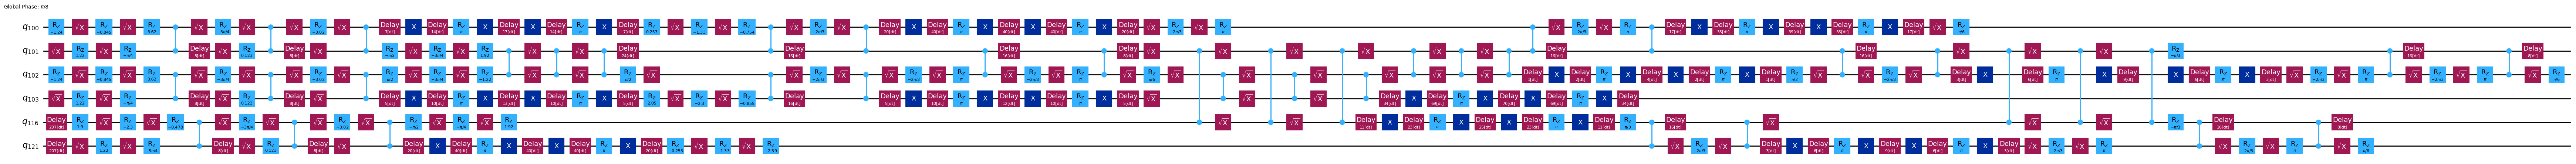

In [146]:
qc_stand_dd = BasisTranslator(sel, basis_gates)(qc_stand_dd)
qc_stand_dd.draw("mpl", fold=-1, idle_wires=False)

In [147]:
estimator.options.max_execution_time = 600

In [148]:
pub_ai_dd = (qc_ai_dd, op_A_ai)
pub_stand_dd = (qc_stand_dd, op_A_stand)

In [160]:
job_result_AI_qc_dd = estimator.run(pubs=[pub_ai_dd]).result()
job_result_AI_qc_dd[0].data.evs

array([[0.74229367],
       [0.78437668],
       [0.93733869]])

In [162]:
job_result_stand_qc_dd = estimator.run(pubs=[pub_stand_dd]).result()
job_result_stand_qc_dd[0].data.evs

array([[0.9119798 ],
       [0.92878448],
       [0.94294851]])

In [163]:
job_result_stand_qc_dd[0].data.stds

array([[0.01114308],
       [0.01140261],
       [0.01081392]])